**Connect to Google Drive**

1. Open the colab file explorer
2. Click the drive icon
3. Click "Connect to drive"

or run the cell below

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r '/content/drive/MyDrive/sign language per kata' .

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
import os


In [ ]:
ORI_DATA_PATH = 'sign language per kata'
IMG_SIZE = 299
BATCH_SIZE = 64
EPOCHS = 500

MAX_SEQ_LENGTH = 100
NUM_FEATURES = 2048

## Load video

In [ ]:
from datasets import load_dataset, DatasetDict, Video, Features

# split 8:1:1
ds = load_dataset("videofolder", data_dir=ORI_DATA_PATH).cast_column("video", Video(decode=False))
ds_train_devtest = ds['train'].train_test_split(test_size=0.2, seed=42)
ds_devtest = ds_train_devtest['test'].train_test_split(test_size=0.5, seed=42)

ds = DatasetDict({
    'train': ds_train_devtest['train'],
    'valid': ds_devtest['train'],
    'test': ds_devtest['test']
})

ds

Resolving data files:   0%|          | 0/531 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['video', 'label'],
        num_rows: 424
    })
    valid: Dataset({
        features: ['video', 'label'],
        num_rows: 53
    })
    test: Dataset({
        features: ['video', 'label'],
        num_rows: 54
    })
})

In [ ]:
label_feature = ds['train'].features['label']
label_names = label_feature.names
label_dict = {i: name for i, name in enumerate(label_names)}

print(label_dict)

{0: 'apa kabar', 1: 'ayo jalan-jalan', 2: 'jaga kesehatan', 3: 'kamu mau kemana', 4: 'kamu tinggal dimana', 5: 'mau pesan apa', 6: 'nama kamu siapa', 7: 'salam kenal', 8: 'sama-sama', 9: 'sampai jumpa lagi', 10: 'saya minta maaf', 11: 'sekarang jam berapa', 12: 'selamat malam', 13: 'selamat pagi', 14: 'selamat siang', 15: 'terima kasih'}


In [ ]:
# def crop_center_square(frame):
#     y, x = frame.shape[0:2]
#     min_dim = min(y, x)
#     start_x = (x // 2) - (min_dim // 2)
#     start_y = (y // 2) - (min_dim // 2)
#     return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

# def load_video(path, max_frames=0):
#     cap = cv2.VideoCapture(path)
#     frames = []
#     try:
#         while True:
#             ret, frame = cap.read()
#             if not ret:
#                 break
#             frame = frame[:, :, [2, 1, 0]]
#             frames.append(frame)

#             if len(frames) == max_frames:
#                 break
#     finally:
#         cap.release()
#     return np.array(frames)

## Extract feature with CNN

In [ ]:
class CenterSquareCrop(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CenterSquareCrop, self).__init__(**kwargs)

    def call(self, inputs):
        # Get the dynamic shape of the input image
        shape = tf.shape(inputs)
        height = shape[1]
        width = shape[2]
        # Determine the side length of the largest possible central square
        crop_size = tf.minimum(height, width)
        # Compute offsets for centering the crop
        offset_height = (height - crop_size) // 2
        offset_width = (width - crop_size) // 2
        # Crop the central square from each image in the batch
        return tf.image.crop_to_bounding_box(inputs, offset_height, offset_width, crop_size, crop_size)

In [ ]:
def build_feature_extractor(training=False):
    feature_extractor = tf.keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling='avg',
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    crop = CenterSquareCrop()
    resize = tf.keras.layers.Resizing(IMG_SIZE,IMG_SIZE)
    preprocess_input = tf.keras.applications.inception_v3.preprocess_input
    inputs = tf.keras.Input(shape=(None, None, 3))
    if training:
        augmentation = tf.keras.Sequential(
            [
                tf.keras.layers.RandomBrightness(0.2),
                tf.keras.layers.RandomContrast(0.2)
            ]
        )
        x = augmentation(inputs)
    else:
        x = inputs
    preprocessed = preprocess_input(resize(crop(x)))

    outputs = feature_extractor(preprocessed)
    return tf.keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor(training=True)
feature_extractor_predict = build_feature_extractor()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
feature_extractor.summary()

Model: "feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ center_square_crop                   │ (None, None, None, 3)       │               0 │
│ (CenterSquareCrop)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
feature_extractor_predict.summary()

Model: "feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ center_square_crop_1                 │ (None, None, None, 3)       │               0 │
│ (CenterSquareCrop)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_1 (Resizing)                │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_1 (TrueDivide)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_1 (Subtract)                │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
tf.keras.backend.clear_session()

### Feature extraction frame by frame

In [ ]:
def prepare_all_videos(ds, split):
    num_samples = len(ds[split])
    video_paths = [video['path'] for video in ds[split]['video']]
    labels = ds[split]['label']

    # Initialize arrays for features and masks
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    for idx, path in enumerate(video_paths):
        # Load and preprocess video frames
        frames = load_video(path)
        video_length = frames.shape[0]

        # Trim or pad frames to MAX_SEQ_LENGTH
        if video_length > MAX_SEQ_LENGTH:
            frames = frames[:MAX_SEQ_LENGTH]
            mask = np.ones(MAX_SEQ_LENGTH, dtype="bool")
        else:
            padding = np.zeros((MAX_SEQ_LENGTH - video_length, *frames.shape[1:]), dtype=frames.dtype)
            frames = np.concatenate([frames, padding], axis=0)
            mask = np.zeros(MAX_SEQ_LENGTH, dtype="bool")
            mask[:video_length] = 1  # Mark valid frames

        # Batch process frames using feature_extractor
        if split in ['test', 'valid']:
            batch_features = feature_extractor_predict.predict(frames, verbose=0)
        else:
            batch_features = feature_extractor.predict(frames, verbose=0)

        # Store features and masks
        frame_features[idx] = batch_features
        frame_masks[idx] = mask

    return (frame_features, frame_masks), labels


# Process datasets
train_data, train_labels = prepare_all_videos(ds, "train")
test_data, test_labels = prepare_all_videos(ds, "test")
valid_data, valid_labels = prepare_all_videos(ds, "valid")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

NameError: name 'ds' is not defined

[220, 100, 2048]

In [ ]:
import pickle
import os

data_types = ['train', 'test', 'valid']
save_dir = '/content/drive/MyDrive/bisindo_data'  # Specify the save directory

for data_type in data_types:
    data_file = os.path.join(save_dir, f'{data_type}_data.pkl')
    labels_file = os.path.join(save_dir, f'{data_type}_labels.pkl')

    with open(data_file, 'wb') as f:
        pickle.dump(eval(f'{data_type}_data'), f)

    with open(labels_file, 'wb') as f:
        pickle.dump(eval(f'{data_type}_labels'), f)

In [ ]:
# prompt: load train,test,valid _data and _labels.pkl from /content/drive/MyDrive/bisindo_data

import pickle
import os

# Load the data and labels from the pickle files
save_dir = '/content/drive/MyDrive/bisindo_data'

train_data = pickle.load(open(os.path.join(save_dir, 'train_data.pkl'), 'rb'))
train_labels = pickle.load(open(os.path.join(save_dir, 'train_labels.pkl'), 'rb'))

test_data = pickle.load(open(os.path.join(save_dir, 'test_data.pkl'), 'rb'))
test_labels = pickle.load(open(os.path.join(save_dir, 'test_labels.pkl'), 'rb'))

valid_data = pickle.load(open(os.path.join(save_dir, 'valid_data.pkl'), 'rb'))
valid_labels = pickle.load(open(os.path.join(save_dir, 'valid_labels.pkl'), 'rb'))

print("Data loaded successfully!")
print(f"Train data shape: {train_data[0].shape}")
print(f"Train labels shape: {len(train_labels)}")

Data loaded successfully!
Train data shape: (424, 100, 2048)
Train labels shape: 424


# Training the sequence model

In [ ]:
# Utility for our sequence model.
def get_sequence_model():
    frame_features_input = tf.keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = tf.keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(frame_features_input, mask=mask_input)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.LSTM(128)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="elu")(x)
    x = tf.keras.layers.Dense(512, activation='elu')(x)
    output = tf.keras.layers.Dense(len(label_names), activation="softmax")(x)

    rnn_model = tf.keras.Model(inputs=[frame_features_input, mask_input], outputs=output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(1e-4),
        metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "video_classifier/ckpt.weights.h5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                      patience=50,
                                                      restore_best_weights=True,
                                                      verbose=1)

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        np.array(train_labels),
        validation_data=([valid_data[0], valid_data[1]], np.array(valid_labels)),
        # validation_split=0.1,
        epochs=EPOCHS,
        callbacks=[checkpoint, early_stopping],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], np.array(test_labels))
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.0798 - loss: 2.7611
Epoch 1: val_loss improved from inf to 2.72550, saving model to video_classifier/ckpt.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.0803 - loss: 2.7606 - val_accuracy: 0.0755 - val_loss: 2.7255
Epoch 2/500
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1129 - loss: 2.7074
Epoch 2: val_loss improved from 2.72550 to 2.66332, saving model to video_classifier/ckpt.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.1142 - loss: 2.7045 - val_accuracy: 0.0943 - val_loss: 2.6633
Epoch 3/500
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1235 - loss: 2.6355
Epoch 3: val_loss improved from 2.66332 to 2.61073, saving model to video_classifier/ckpt.weights.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.1281 - loss: 2.6358 - val_accuracy: 0.1887 - val_loss: 2.6107
Epoch 4/500
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1659 - loss: 2.5654
Epoch 4:

In [ ]:
# prompt: save the seq_model to drive

# Save the model to Google Drive
model_save_path = os.path.join(save_dir, 'seq_model.keras')  # Specify the desired save location
sequence_model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/bisindo_data/seq_model.keras


# Evaluating

In [ ]:
sequence_model = tf.keras.models.load_model('/content/drive/MyDrive/bisindo_data/seq_model.keras')

Test video path: /content/drive/.shortcut-targets-by-id/1Fky3tmaW1yysKeyRa2yjBC5NFyv1RaYa/sign language per kata/selamat pagi/Movie on 01-03-25 at 22.10 #6.mov
(1, 100, 2048)
(1, 100)
  selamat pagi: 99.63%
  selamat siang:  0.15%
  ayo jalan-jalan:  0.09%
  selamat malam:  0.06%
  kamu mau kemana:  0.06%
  nama kamu siapa:  0.00%
  salam kenal:  0.00%
  saya minta maaf:  0.00%
  mau pesan apa:  0.00%
  kamu tinggal dimana:  0.00%
  apa kabar:  0.00%
  terima kasih:  0.00%
  sekarang jam berapa:  0.00%
  jaga kesehatan:  0.00%
  sampai jumpa lagi:  0.00%
  sama-sama:  0.00%


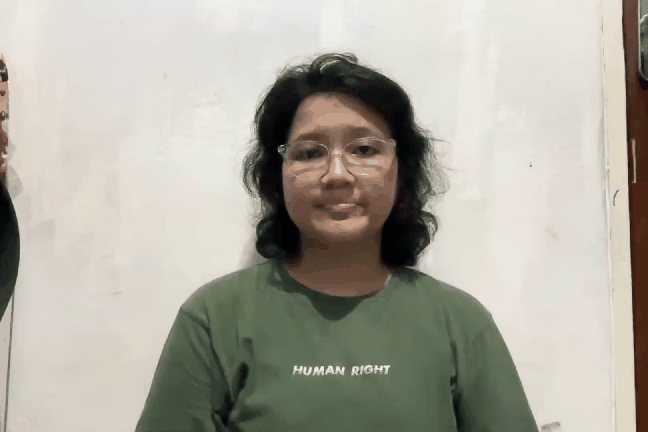

In [ ]:
import imageio
from IPython.display import display
from PIL import Image

def prepare_single_video(frames):
    # Load and preprocess video frames
    video_length = frames.shape[0]

    # Trim or pad frames to MAX_SEQ_LENGTH
    if video_length > MAX_SEQ_LENGTH:
        frames = frames[:MAX_SEQ_LENGTH]
        mask = np.ones(MAX_SEQ_LENGTH, dtype="bool")
    else:
        padding = np.zeros((MAX_SEQ_LENGTH - video_length, *frames.shape[1:]), dtype=frames.dtype)
        frames = np.concatenate([frames, padding], axis=0)
        mask = np.zeros(MAX_SEQ_LENGTH, dtype="bool")
        mask[:video_length] = 1  # Mark valid frames

    # Batch process frames using feature_extractor
    features = feature_extractor_predict.predict(frames, verbose=0)

    return np.expand_dims(features, axis=0), np.expand_dims(mask, axis=0)


def sequence_prediction(path):
    class_vocab = label_names

    frames = load_video(path)
    frame_features, frame_mask = prepare_single_video(frames)
    print(frame_features.shape)
    print(frame_mask.shape)
    probabilities = sequence_model.predict([frame_features, frame_mask], verbose=False)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=100)
    image = Image.open('animation.gif')
    scale = 0.4
    display(image.resize(( int(image.width * scale), int(image.height * scale))))


test_video = np.random.choice(ds['test']['video'])
print(f"Test video path: {test_video['path']}")
test_frames = sequence_prediction(test_video['path'])
to_gif(test_frames[:MAX_SEQ_LENGTH])